Пример задачи оптимизации для производства

$$
f(x, b) = \max_y c^T x - c^T_b b - c^T_a y \\
\text{s.t.} ~~ Ax \leq b + y
$$

Подразумевается, что $x$ семплируется случайно, $b$ выбираем в начале, это интерпретируется как закупки в начале по оптовым ценам.

Также цены могут семплироваться случайно.

$y$ здесь закупки по ценам побольше.

Нужно при планируемом бюджете на начало периода принимать решение о распределении денег.

В качестве $b_i$ рассмотрим b, которые оказались достаточными для этого $x$

то есть $b_i = Ax_i$. 

Это нижняя оценка на траты в  этом периоде.

Проводится три исследования зависимости:
1. для разных бюджетов считаем получающиеся gamma и реальное отношение значений функций. 
2. сравниваем получающиеся отношения для точного решения и приближенного.
3. сравнение времен работ этих алгоритмов


In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from tqdm import tqdm

# generator of data for experiment
from paper_code.simple_example.consumption_exp_generator import generate_cases

# function to compute gamma for proposed budget
from paper_code.simple_example.exact_solver import gamma_exact

# function to compute exact gamma
from paper_code.altorithm import gamma_for_budget

from paper_code.utils.timer import timer
from paper_code.utils.exp_runner import compute_for_budgets
from paper_code.utils.drawer import plot_ratios

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def get_ratios(b_s, cases, values):
    """
    computes exact solutions for founded b for different budgets
    """
    ratios = []
    for i in range(len(b_s)):
        b = b_s[i]
        new_values = np.array([f(b, True)[0] for f in cases])    
        ratio = new_values/values
        ratios.append(ratio)
    ratios = np.array(ratios)
    return ratios


In [10]:
num_cases = 40
num_resources = 100
num_products = 50
cases, values, budgets = generate_cases(m = num_cases, n = num_resources, k = num_products)

# inputs for algorithms
c_x = cases[0].cb
x_s = np.array(budgets)
v_s = np.array(values)
L_s = np.array(([ max((c.ca- c.cb).max(), c.cb.max()) for c in cases]))

# budgets to test
used_budgets = np.array([b @ c_x for b in budgets])
maxx = np.max(used_budgets)
max_budgets = np.linspace(maxx / 10, maxx* 1.5, 25)

In [11]:
rezults = []

y1 = r"$f_i(b)~/~f_i(b_i)$"
x1 = r"Maximal budget, $B$"
l1 = r"$1 + \gamma \cdot C$"

## for L1 norm
L_s = np.array(([ max((c.ca- c.cb).max(), c.cb.max()) for c in cases]))
b_s, gammas, _ = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, budget_init=None, cases = cases, norm=1, n_jobs= 10)
ratios = get_ratios(b_s, cases, values)
rez = {"name": r"$L_1$ norm", "ratios": ratios, "gammas": gammas, "x1": x1, "y1": y1,"l1": l1,"b_s": b_s}
rezults.append(rez)

## for L2 norm
L_s =  np.array(([ np.linalg.norm(np.maximum(np.abs(c.ca- c.cb), c.cb)) for c in cases]))
b_s, gammas, _ = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, budget_init = None, cases = None,  exact= False, norm=2, n_jobs= 10)
ratios = get_ratios(b_s, cases, values)
rez = {"name": r"$L_2$ norm", "ratios": ratios, "gammas": gammas, "x1": x1, "y1": y1,"l1": l1,"b_s": b_s}
rezults.append(rez)

L_s =  np.array(([ 100 for c in cases]))
b_s, gammas, _ = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, budget_init = None, cases = None,  exact= False, norm=2, n_jobs= 10)
ratios = get_ratios(b_s, cases, values)
rez = {"name": r"$L_2$ norm, $L_i = 100$", "ratios": ratios, "gammas": gammas, "x1": x1, "y1": y1,"l1": l1,"b_s": b_s}
rezults.append(rez)


# y1 = r"$f_i(x)/v_i$"
# x1 = r"Maximal budget, $B$"
l1 = r"$1 + \gamma$"
## exact solution
b_s_ex, gammas_ex, _ = compute_for_budgets(c_x, x_s, v_s, L_s, max_budgets, budget_init = None, cases = cases, exact= True, n_jobs= 10)
ratios_ex = get_ratios(b_s_ex, cases, values)
rez = {"name": "Exact", "ratios": ratios_ex, "gammas": gammas_ex, "x1": x1, "y1": y1,"l1": l1, "b_s": b_s_ex}
rezults.append(rez)

/Users/ilgam/miniconda3/envs/lol/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/ilgam/miniconda3/envs/lol/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/ilgam/miniconda3/envs/lol/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/ilgam/miniconda3/envs/lol/lib/python3.12/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warning

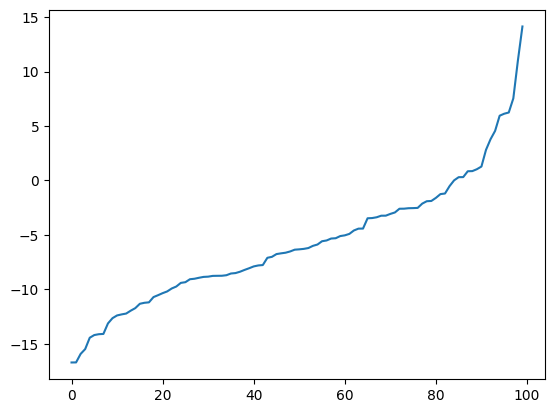

In [12]:
plt.plot(sorted((rezults[-1]['b_s'][-4] - rezults[-2]['b_s'][-4])))

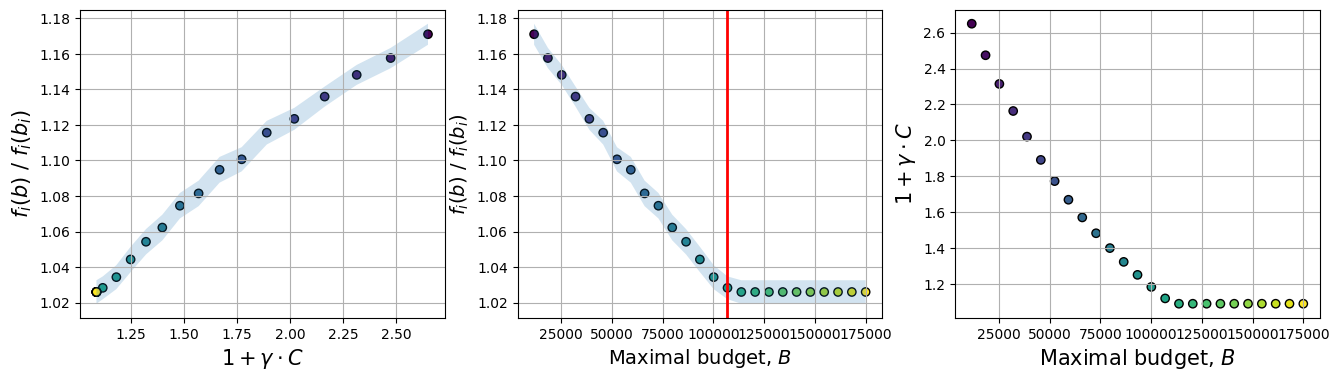

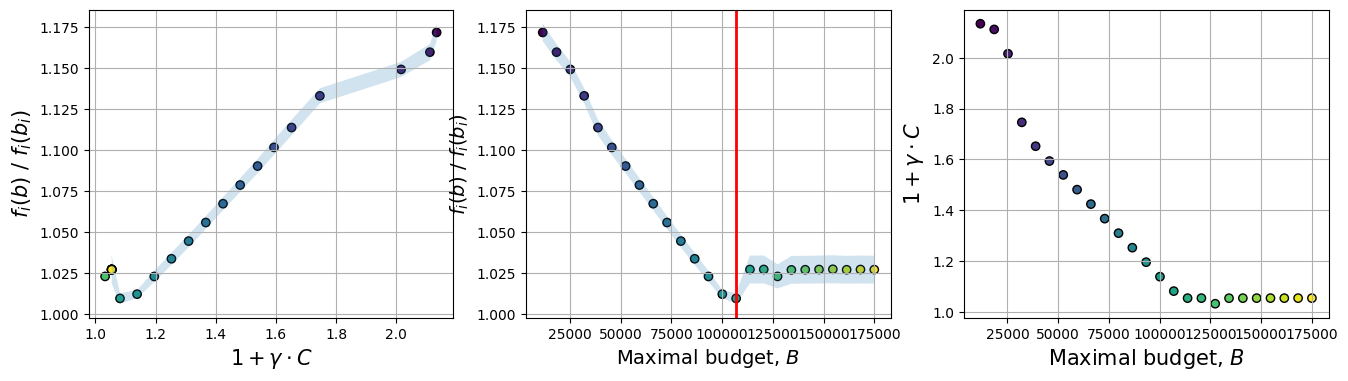

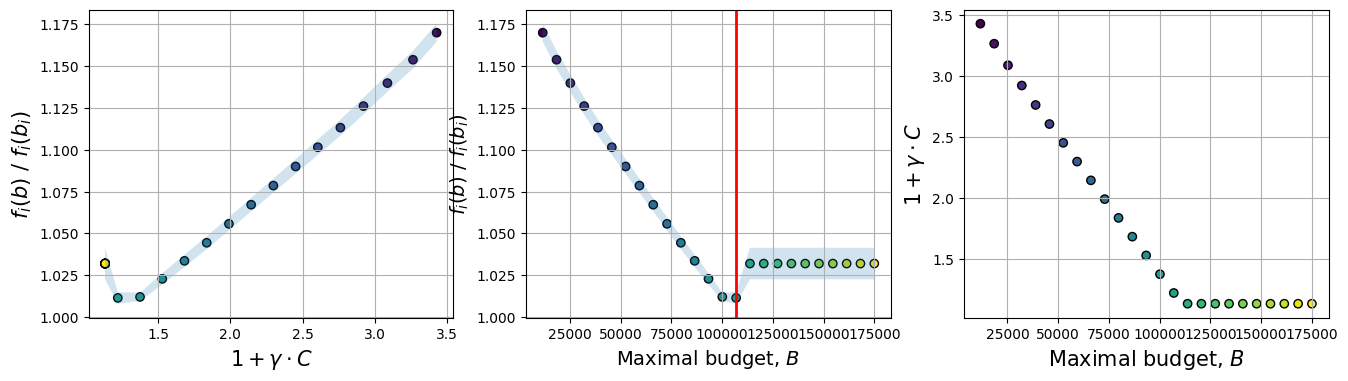

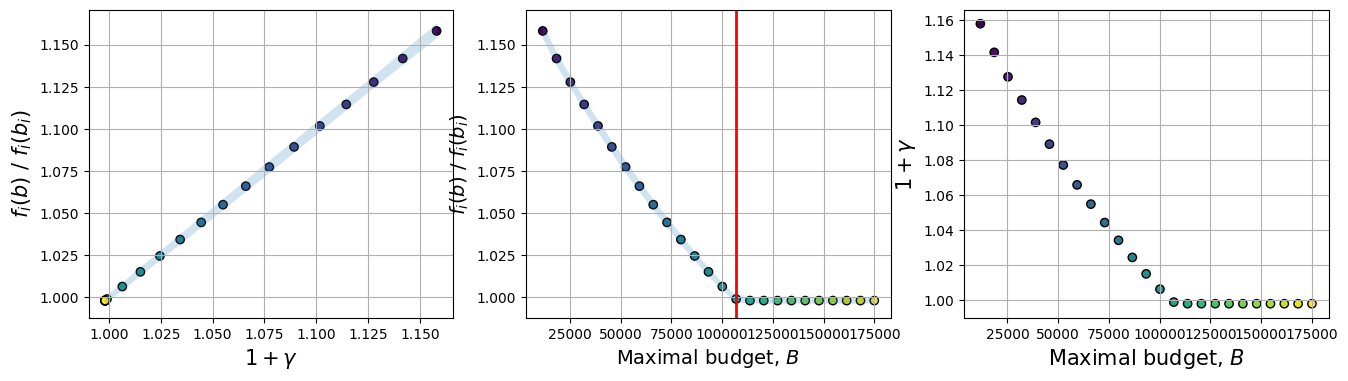

In [13]:
for r in rezults:
    fig = plot_ratios(**r, max_budgets= max_budgets, used_budgets=used_budgets)

In [14]:
import seaborn as sns
DPI = 200
def get_fig_set_style(lines_count, shape=(1, 1), figsize=None):
    params = {
        "legend.fontsize": 10,
        "lines.markersize": 10,
        "axes.labelsize": 15,
        "axes.titlesize": 18,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "font.size": 15,
        #  "text.usetex": True
    }
    sns.set_context("paper", rc=params)
    # sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 2.5})
    if figsize is None:
        fig, ax = plt.subplots(*shape, dpi=DPI)
    else:
        fig, ax = plt.subplots(*shape, dpi=DPI, figsize=figsize)
    # plt.rcParams['text.usetex'] = True
    # plt.rcParams['text.latex.unicode'] = True
    plt.grid(which="both")
    return fig, ax


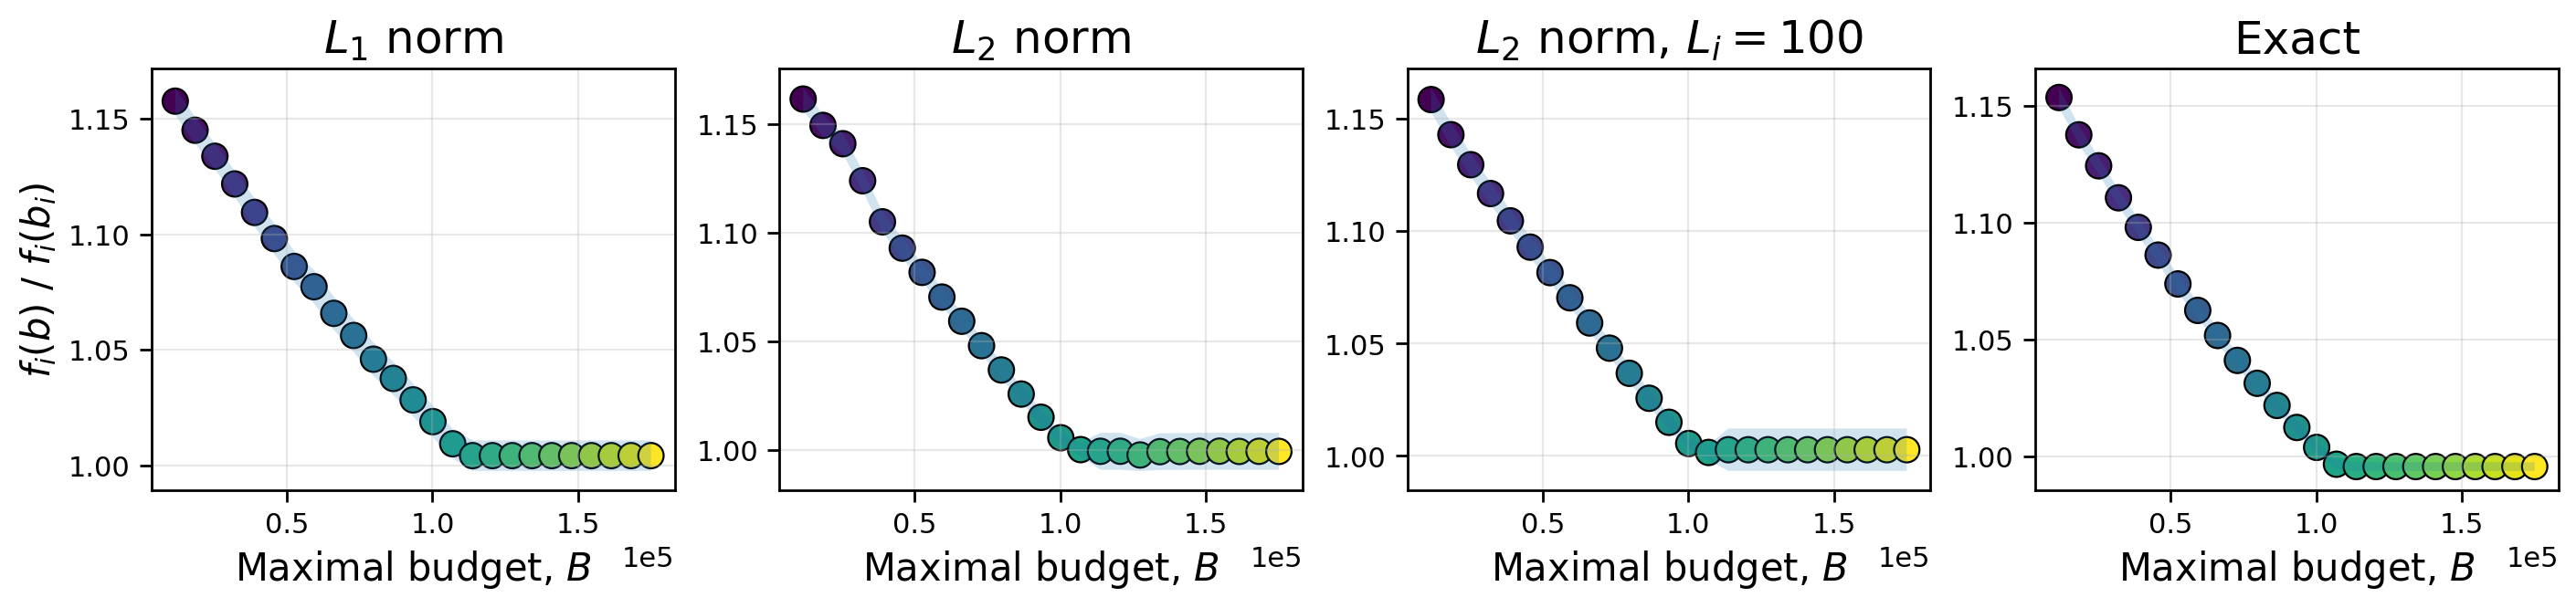

In [15]:
# plt.rc('axes', labelsize=14) 
# fig, ax = plt.subplots(1,4, figsize = (15, 3))
fig, ax = get_fig_set_style(None, (1,4), (17,3))
for i, rez in enumerate(rezults):
    ratios = rez['ratios']
    gammas = rez['gammas']
    ratios_stat = np.array([(np.mean(r), np.std(r)) for r in ratios]).T
    gm = (1 + np.array(gammas)) #1/(1 - np.array(gammas))
    colors = np.linspace(0, 2., len(gm))

    ax[i].scatter(max_budgets , ratios_stat[0], c = colors, ec = 'k')
    ax[i].fill_between(max_budgets , ratios_stat[0] - ratios_stat[1], ratios_stat[0] + ratios_stat[1], alpha = 0.2)
    ax[i].grid(which="major", alpha=0.3)
    ax[i].set_title(rez['name'])
    ax[i].set_xlabel(x1)
    ax[i].ticklabel_format(axis="x", scilimits=[-3, 3])
ax[0].set_ylabel(y1)
plt.show()

Text(0.5, 0, 'Maximal budget, $B$')

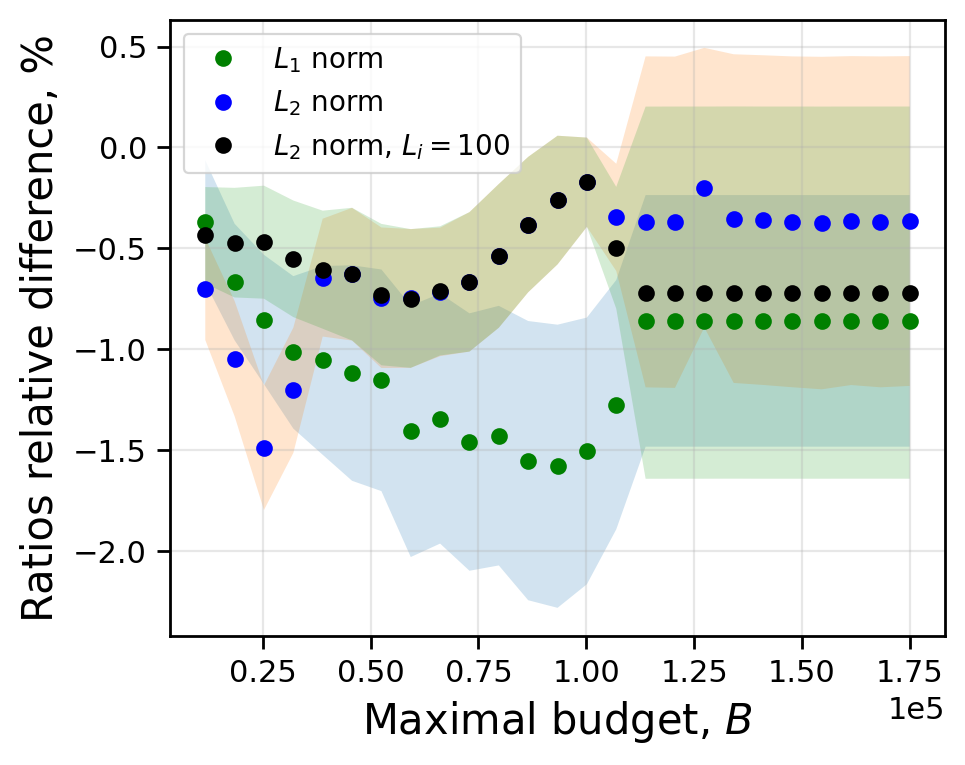

In [16]:
colors = [ 'green', "blue", 'black']
fig, ax = get_fig_set_style(None, (1,1), (5,4))
# plt.figure(figsize = (5,4), dpi = 200)
for i, r in enumerate(rezults[:-1]):
    ratios = r['ratios']
    ratios_diff = (ratios_ex - ratios)/(ratios_ex)
    ratios__diff_stat = np.array([(np.mean(r), np.std(r)) for r in ratios_diff]).T * 100
    # colors =  np.linspace(0, 2., len(max_budgets))
    # plt.scatter(max_budgets, (ratios_diff).mean(1), c = colors, ec = 'k')
    ax.plot(max_budgets, ratios__diff_stat[0], '.', color = colors[i], label = f"{r["name"]}")
    ax.fill_between(max_budgets, ratios__diff_stat[0] - ratios__diff_stat[1], ratios__diff_stat[0] + ratios__diff_stat[1], alpha = 0.2)
ax.ticklabel_format(axis="x", scilimits=[-3, 3])
ax.grid(which="major", alpha=0.3)
ax.legend(loc="upper left")
ax.set_ylabel("Ratios relative difference, %", fontsize = 15)
ax.set_xlabel(x1, fontsize = 15)
# plt.ticklabel_format(axis="y", scilimits=[-2, 2])
